# generate brick profile

## visualize the cutlines

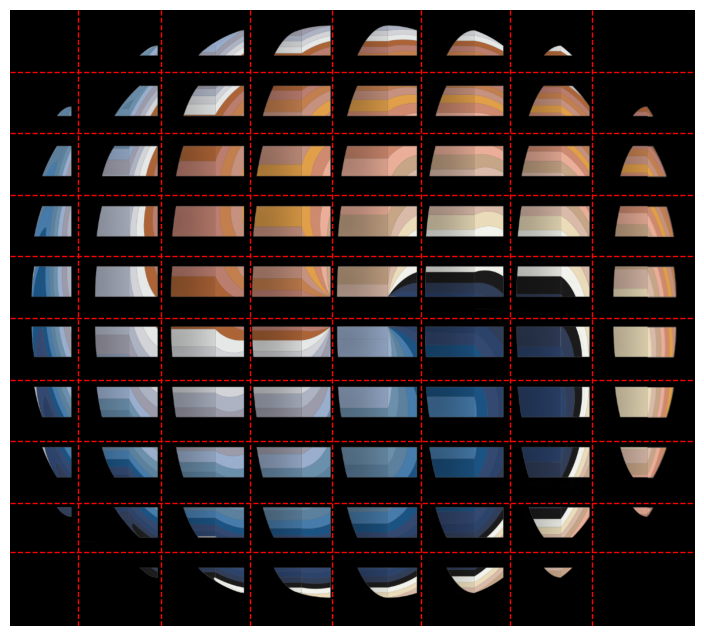

In [28]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from skimage.color import rgba2rgb


def visualize_grid(img_array, x_percent, y_percent):
    img_width, img_height = img_array.shape[1], img_array.shape[0]
    x_positions = [int(img_width * (p / 100.0)) for p in x_percent]
    y_positions = [int(img_height * (p / 100.0)) for p in y_percent]

    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(img_array)
    for x in x_positions:
        ax.axvline(x, color='r', linestyle='--', linewidth=1)
    for y in y_positions:
        ax.axhline(y, color='r', linestyle='--', linewidth=1)

    ax.axis('off')
    plt.show()


# Load the image
image_path = 'crop.png'  # Replace with your image path
image = Image.open(image_path)
image_array = np.array(image)
if image_array.shape[2] == 4:
    image_array = rgba2rgb(image_array)

# Define the percentages for x and y as provided
x_percent = [10, 22, 35, 47, 60, 73, 85]
y_percent = [10, 20, 30, 40, 50, 60, 70, 80, 88]

# Visualize the grid on the image
visualize_grid(image_array, x_percent, y_percent)

## Divide and organize into cells

In [29]:
# Function to generate label based on row and column index
def generate_label(row, col):
    return f"{chr(97 + col)}{row + 1}"


# Function to divide the image into cells
def divide_into_cells(img, x_pct, y_pct):
    img_width, img_height = img.size
    x_bounds = [0] + [int(img_width * (p / 100.0)) for p in x_pct] + [img_width]
    y_bounds = [0] + [int(img_height * (p / 100.0)) for p in y_pct] + [img_height]

    cells = {}
    for i in range(len(y_bounds) - 1):
        for j in range(len(x_bounds) - 1):
            cell = img.crop((x_bounds[j], y_bounds[i], x_bounds[j + 1], y_bounds[i + 1]))
            label = generate_label(i, j)
            cells[label] = np.array(cell)

    return cells


cells = divide_into_cells(image, x_percent, y_percent)


## Obtain color from each cell

### Approach 1: Edge Detection

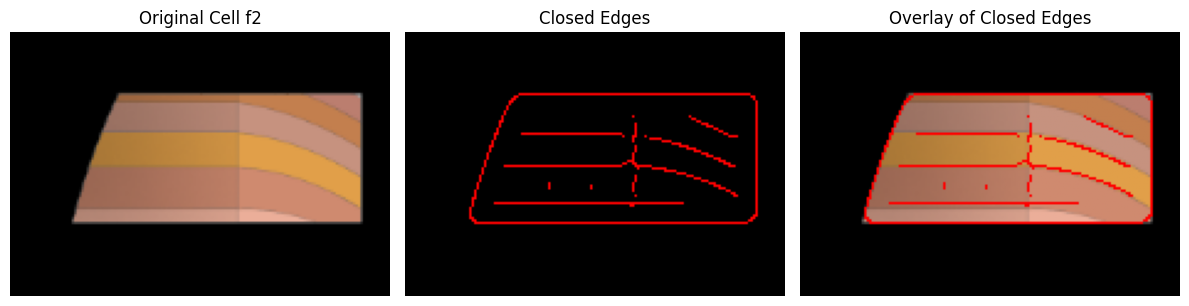

In [30]:
from skimage.feature import canny
from skimage.color import rgb2gray, rgba2rgb
from skimage.morphology import closing, square


# Function to perform edge detection with morphological closing
def detect_edges_with_closing(
    img_array, sigma=3, low_threshold=0.005, high_threshold=0.01, square_size=2
):
    if img_array.shape[2] == 4:
        img_array = rgba2rgb(img_array)

    gray_img = rgb2gray(img_array)
    edges = canny(
        gray_img,
        sigma=sigma,
        low_threshold=low_threshold,
        high_threshold=high_threshold,
    )
    closed_edges = closing(edges, square(square_size))

    closed_edge_img = np.zeros(img_array.shape)
    closed_edge_img[closed_edges] = [1, 0, 0]  # Red edges
    overlay_img = img_array.copy()
    overlay_img[closed_edges] = [1, 0, 0]  # Red edges on original

    return closed_edge_img, overlay_img


# Select a cell to perform edge detection, for example 'e1'
cell_label = "f2"  # Replace with the cell label you want to analyze
closed_edge_img, overlay_closed_img = detect_edges_with_closing(cells[cell_label])

# Display the results
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(cells[cell_label])
axes[0].set_title(f"Original Cell {cell_label}")
axes[0].axis("off")

axes[1].imshow(closed_edge_img)
axes[1].set_title("Closed Edges")
axes[1].axis("off")

axes[2].imshow(overlay_closed_img)
axes[2].set_title("Overlay of Closed Edges")
axes[2].axis("off")

plt.tight_layout()
plt.show()

### Approach 2: K-mean Color Clustering

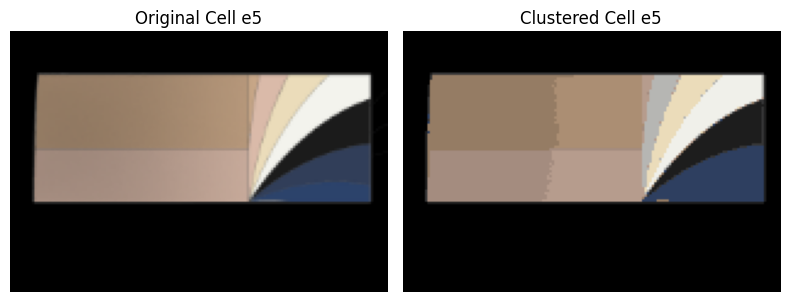

[[182, 156, 141],
 [54, 54, 55],
 [240, 240, 234],
 [171, 142, 115],
 [29, 29, 29],
 [46, 63, 96],
 [149, 124, 100],
 [182, 182, 179],
 [235, 220, 186],
 [164, 140, 127]]

In [31]:
from sklearn.utils import shuffle
from sklearn.cluster import KMeans


def k_cluster(cell_img_array, n_clusters=10, n_samples=100, black_threshold=30):
    """
    Perform color clustering within a cell ignoring black or near-black pixels.

    Parameters:
    - cell_img_array: The array representation of the cell image.
    - n_clusters: The number of clusters to form.
    - n_samples: The number of pixels to sample for clustering to speed up the process.
    - black_threshold: The sum of RGB values below which a pixel is considered black or near-black.

    Returns:
    - A list of the cluster center colors.
    - An image showing the clustered cell.
    """
    # Check if the image has an alpha channel; if so, remove it
    if cell_img_array.shape[2] == 4:
        cell_img_array = cell_img_array[:, :, :3]

    # Flatten the image array and remove black/near-black pixels
    pixels = cell_img_array.reshape((-1, 3))
    non_black_pixels = pixels[np.sum(pixels, axis=1) > black_threshold]

    # If there are not enough pixels for the sample, reduce n_samples or use all pixels
    n_samples = min(n_samples, non_black_pixels.shape[0])

    # Randomly sample a subset of pixels for KMeans to speed up the process
    pixels_sample = shuffle(non_black_pixels, random_state=0)[:n_samples]

    # Fit the KMeans model to the sampled pixels
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(pixels_sample)

    # Predict the cluster for all non-black pixels
    labels = kmeans.predict(non_black_pixels)

    # Create an image to visualize the clusters
    cluster_img = np.zeros_like(cell_img_array)
    for label, pixel in zip(labels, non_black_pixels):
        cluster_img[np.all(cell_img_array == pixel, axis=-1)] = kmeans.cluster_centers_[
            label
        ]

    # Extract the cluster center colors
    cluster_colors = kmeans.cluster_centers_.astype(int)

    return cluster_colors, cluster_img


# Test the function with one of the cells, let's say 'e1'
cell_name = "e5"
cluster_colors, cluster_image = k_cluster(cells[cell_name])

# Display the original cell and the clustered cell
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(cells[cell_name])
ax1.set_title(f"Original Cell {cell_name}")
ax1.axis("off")

ax2.imshow(cluster_image)
ax2.set_title(f"Clustered Cell {cell_name}")
ax2.axis("off")

plt.tight_layout()
plt.show()

# Output the list of cluster colors for cell 'e1'
cluster_colors.tolist()

### Approach 3: DBSCAN Clustering

Detected 8 color blocks.


(-0.5, 154.5, 106.5, -0.5)

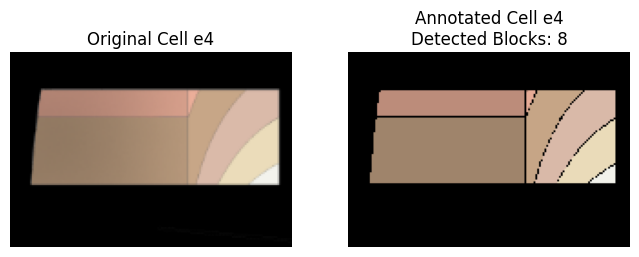

In [32]:
from sklearn.cluster import DBSCAN
from skimage.color import rgb2lab
import numpy as np
import matplotlib.pyplot as plt


def find_color_blocks_dbscan(img_array, eps=4, min_samples=10) -> tuple[np.ndarray, int]:
    """
    Detect color blocks in an image using DBSCAN clustering.
    
    Parameters:
    - image_array: Numpy array of the image.
    - eps: The maximum distance between two samples for one to be considered as in the neighborhood of the other.
    - min_samples: The number of samples in a neighborhood for a point to be considered as a core point.
    
    Returns:
    - Annotated image showing different color blocks.
    - Number of detected color blocks.
    """
    # Check if the image has an alpha channel; if so, remove it
    if img_array.shape[2] == 4:
        img_array = img_array[:, :, :3]  # Correctly remove the alpha channel

    # Convert the image to Lab color space for better color difference measurement
    lab_image = rgb2lab(img_array)

    # Prepare data for clustering (combining color and spatial information)
    rows, cols, _ = lab_image.shape
    X = np.c_[lab_image.reshape((-1, 3)), np.indices((rows, cols)).reshape((2, -1)).T]

    # Apply DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
    labels = dbscan.fit_predict(X)

    # Count unique labels to get the number of color blocks (excluding noise)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    # Create an annotated image to visualize the clusters
    annotated_image = np.zeros_like(img_array)
    for label in set(labels):
        if label != -1:  # Ignore noise
            points = labels == label
            annotated_image[points.reshape(rows, cols)] = np.mean(img_array[points.reshape(rows, cols)], axis=0)
    print(f"Detected {n_clusters} color blocks.")
    return annotated_image, n_clusters


# Example usage with a cell from the cells dictionary
cell_name = 'e4'
cell_image_array = cells[cell_name]

annotated_cell_image, n_color_blocks = find_color_blocks_dbscan(cell_image_array)

# Display the original cell and the annotated cell
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(cells[cell_name])
ax1.set_title(f'Original Cell {cell_name}')
ax1.axis('off')

ax2.imshow(annotated_cell_image)
ax2.set_title(f'Annotated Cell {cell_name}\nDetected Blocks: {n_color_blocks}')
ax2.axis('off')

## Final result

Detected 1 color blocks.
No color parameters found for a1
Detected 3 color blocks.
Plotting b1 brick wall


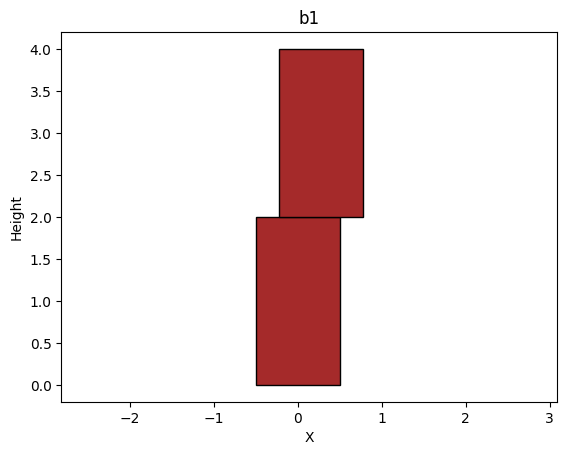

Saving plot to output/b1.png)
Detected 7 color blocks.
Plotting c1 brick wall


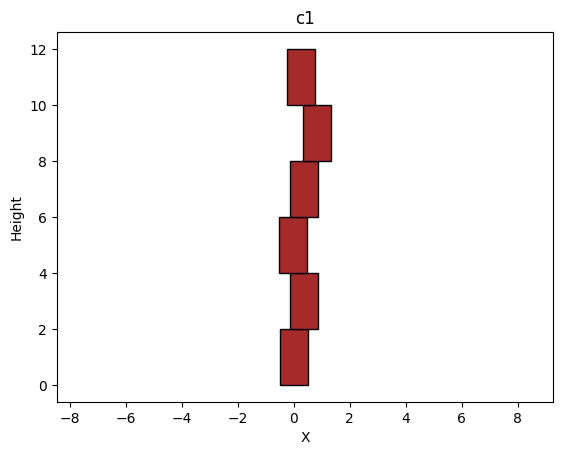

Saving plot to output/c1.png)
Detected 8 color blocks.
Plotting d1 brick wall


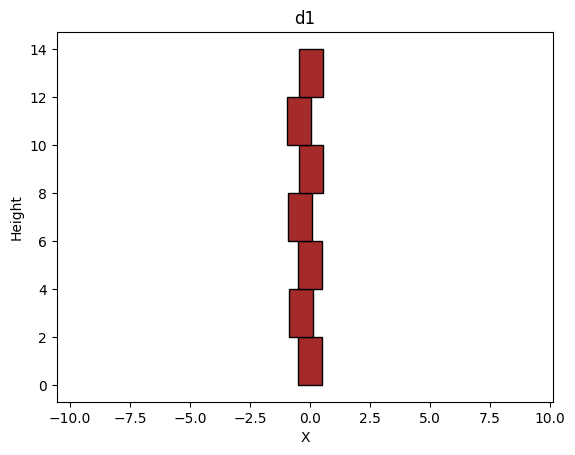

Saving plot to output/d1.png)
Detected 6 color blocks.
Plotting e1 brick wall


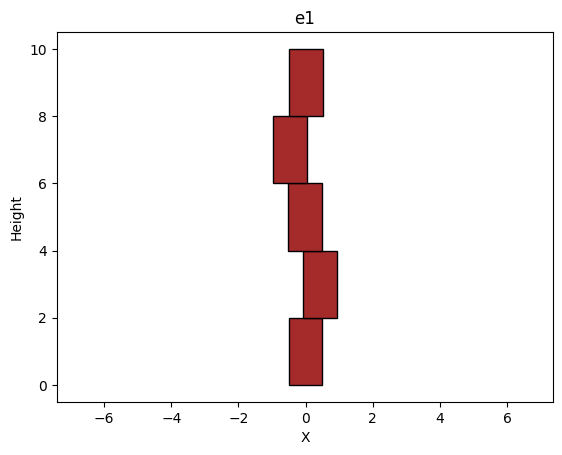

Saving plot to output/e1.png)
Detected 10 color blocks.
Plotting f1 brick wall


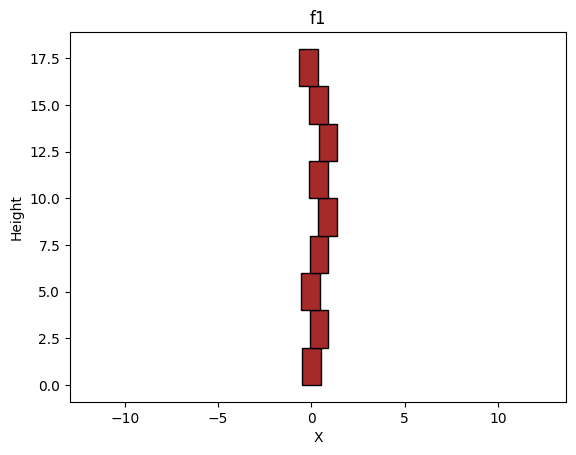

Saving plot to output/f1.png)
Detected 5 color blocks.
Plotting g1 brick wall


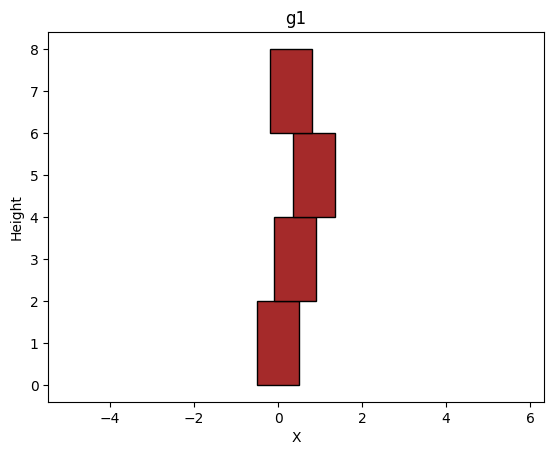

Saving plot to output/g1.png)
Detected 1 color blocks.
No color parameters found for h1
Detected 3 color blocks.
Plotting a2 brick wall


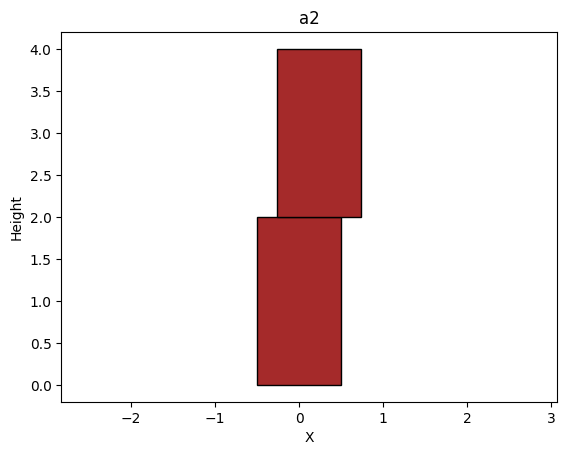

Saving plot to output/a2.png)
Detected 7 color blocks.
Plotting b2 brick wall


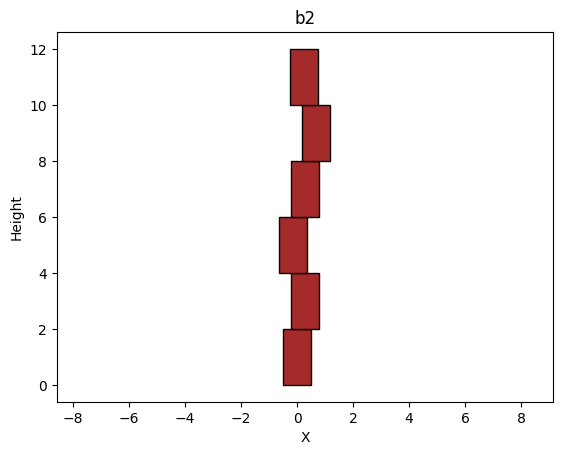

Saving plot to output/b2.png)
Detected 9 color blocks.
Plotting c2 brick wall


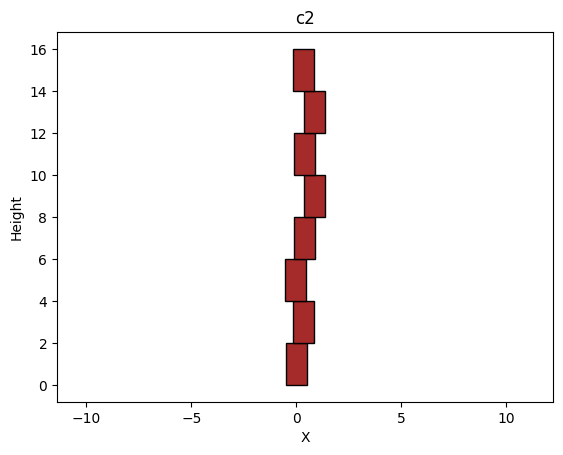

Saving plot to output/c2.png)
Detected 9 color blocks.
Plotting d2 brick wall


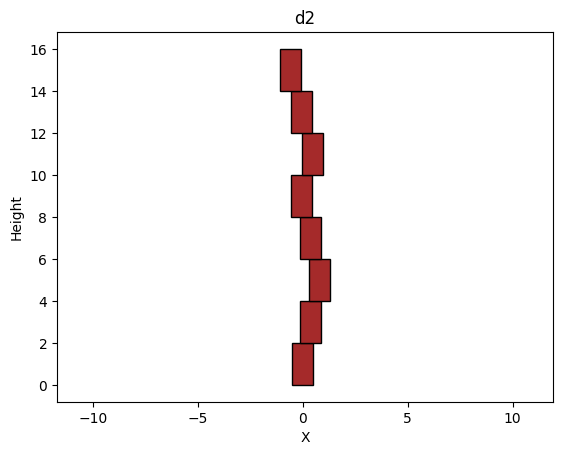

Saving plot to output/d2.png)
Detected 11 color blocks.
Plotting e2 brick wall


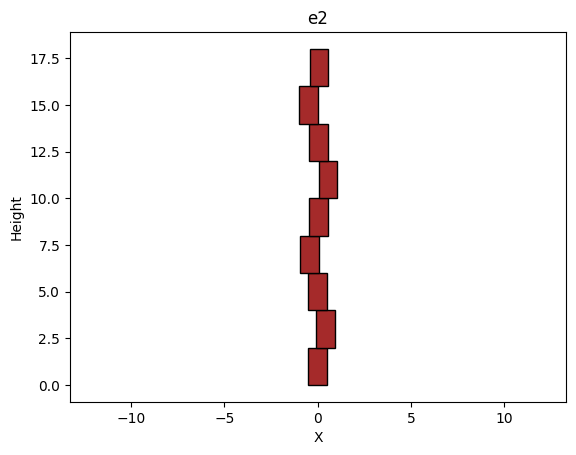

Saving plot to output/e2.png)
Detected 12 color blocks.
Plotting f2 brick wall


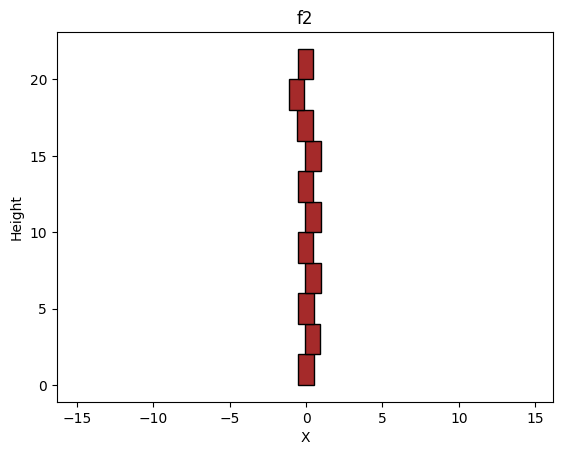

Saving plot to output/f2.png)
Detected 13 color blocks.
Plotting g2 brick wall


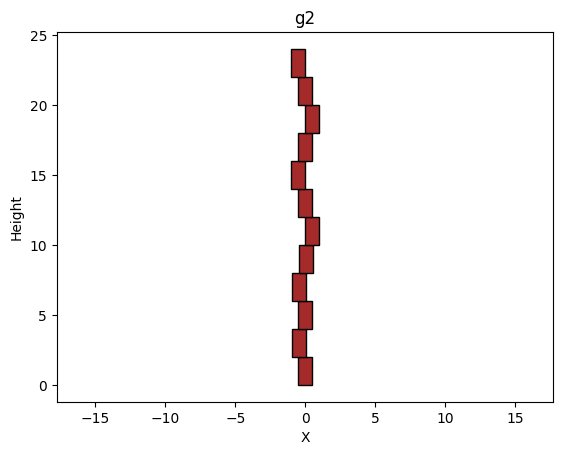

Saving plot to output/g2.png)
Detected 3 color blocks.
Plotting h2 brick wall


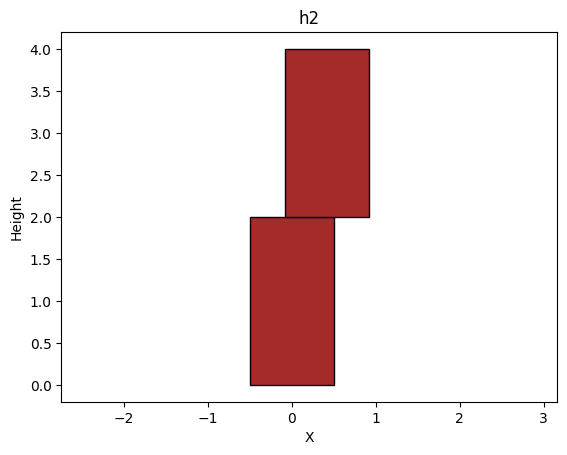

Saving plot to output/h2.png)
Detected 4 color blocks.
Plotting a3 brick wall


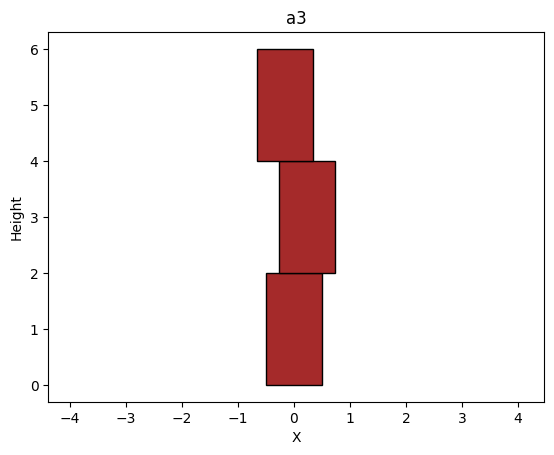

Saving plot to output/a3.png)
Detected 10 color blocks.
Plotting b3 brick wall


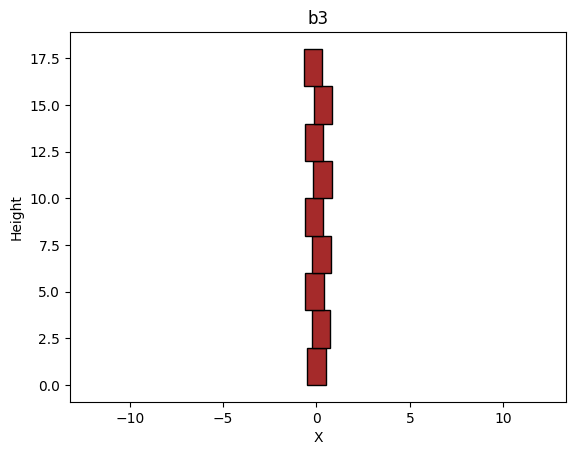

Saving plot to output/b3.png)
Detected 7 color blocks.
Plotting c3 brick wall


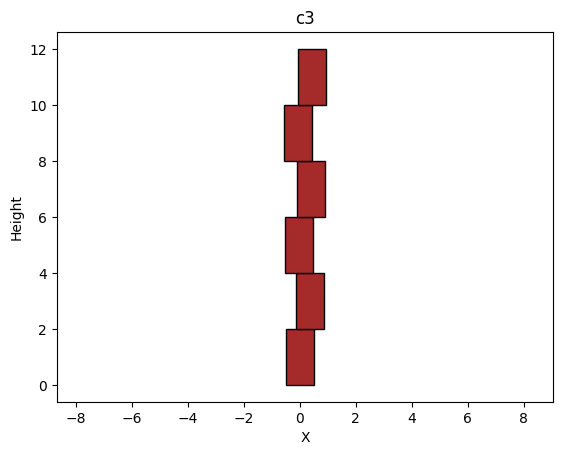

Saving plot to output/c3.png)
Detected 7 color blocks.
Plotting d3 brick wall


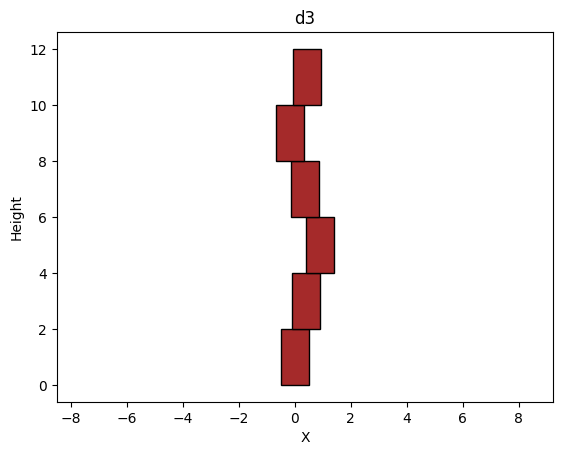

Saving plot to output/d3.png)
Detected 7 color blocks.
Plotting e3 brick wall


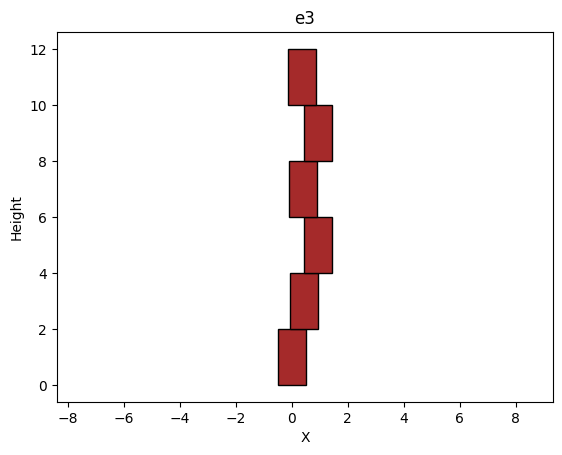

Saving plot to output/e3.png)
Detected 8 color blocks.
Plotting f3 brick wall


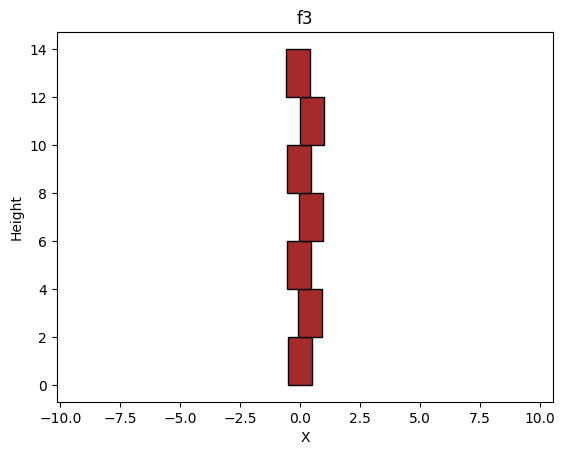

Saving plot to output/f3.png)
Detected 11 color blocks.
Plotting g3 brick wall


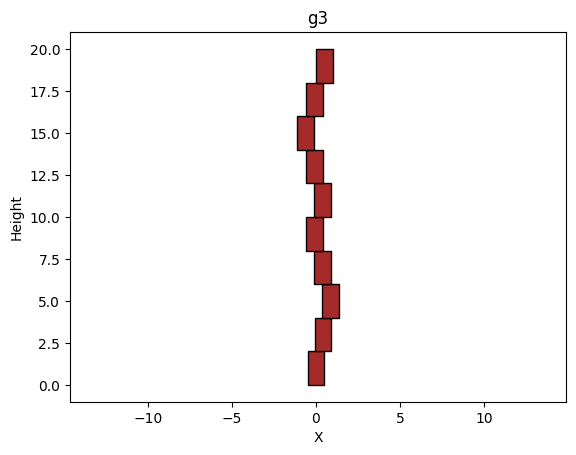

Saving plot to output/g3.png)
Detected 8 color blocks.
Plotting h3 brick wall


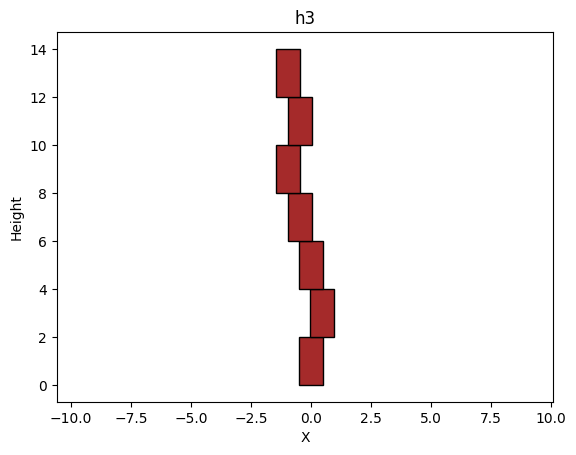

Saving plot to output/h3.png)
Detected 8 color blocks.
Plotting a4 brick wall


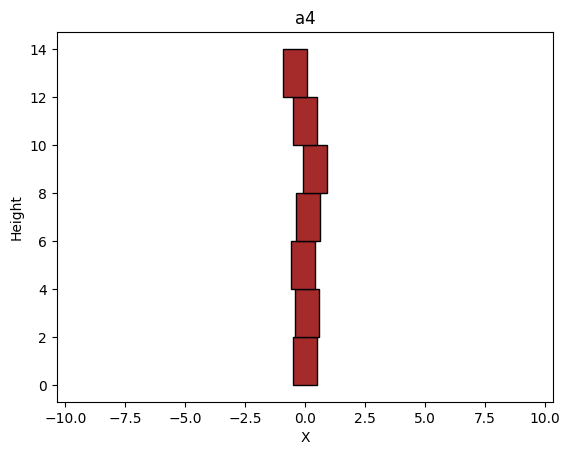

Saving plot to output/a4.png)
Detected 5 color blocks.
Plotting b4 brick wall


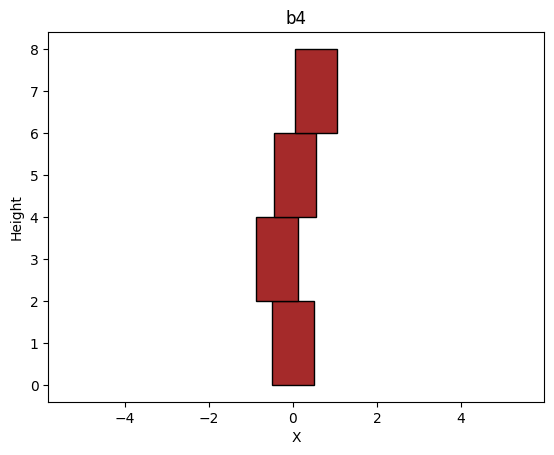

Saving plot to output/b4.png)
Detected 5 color blocks.
Plotting c4 brick wall


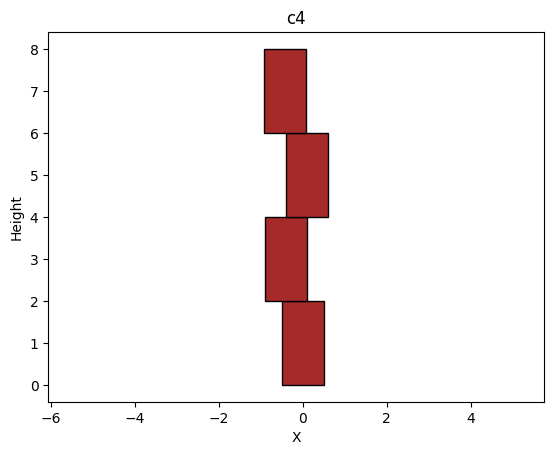

Saving plot to output/c4.png)
Detected 8 color blocks.
Plotting d4 brick wall


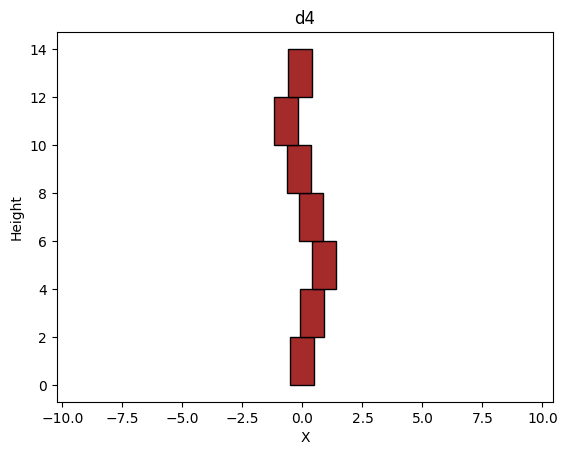

Saving plot to output/d4.png)
Detected 8 color blocks.
Plotting e4 brick wall


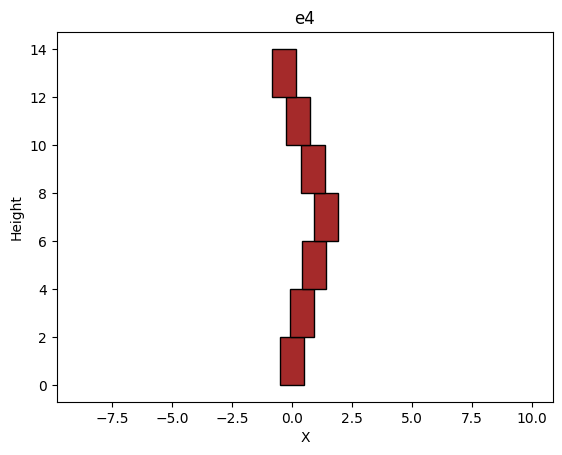

Saving plot to output/e4.png)
Detected 7 color blocks.
Plotting f4 brick wall


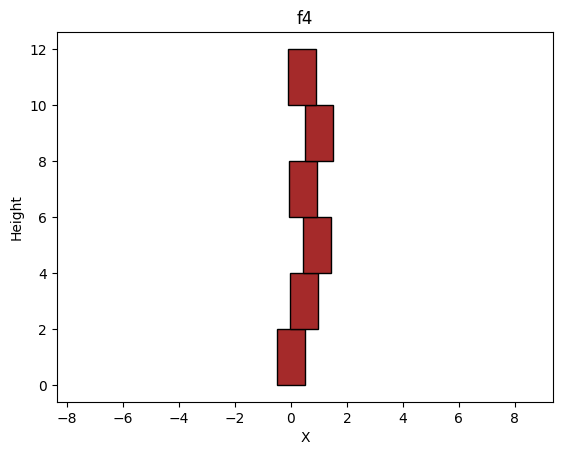

Saving plot to output/f4.png)
Detected 10 color blocks.
Plotting g4 brick wall


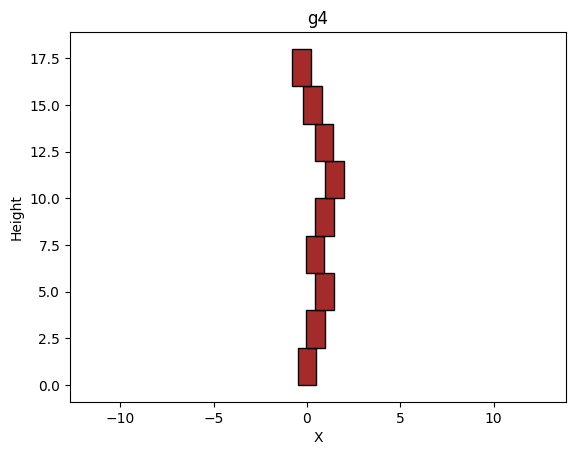

Saving plot to output/g4.png)
Detected 10 color blocks.
Plotting h4 brick wall


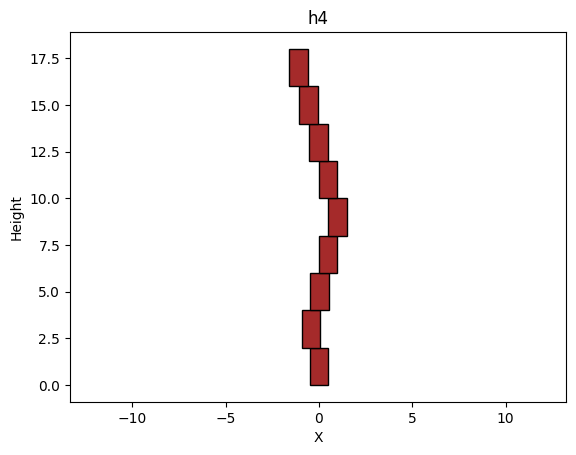

Saving plot to output/h4.png)
Detected 8 color blocks.
Plotting a5 brick wall


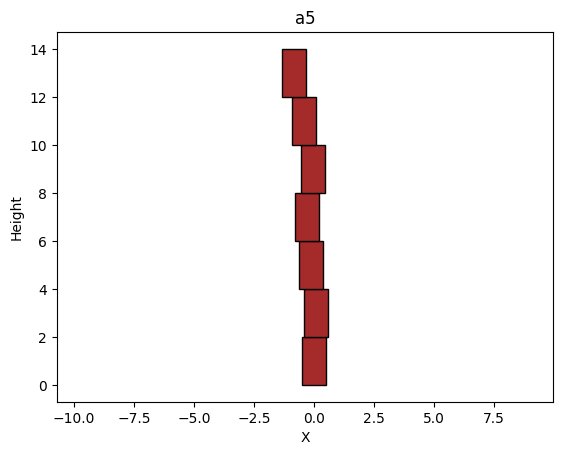

Saving plot to output/a5.png)
Detected 5 color blocks.
Plotting b5 brick wall


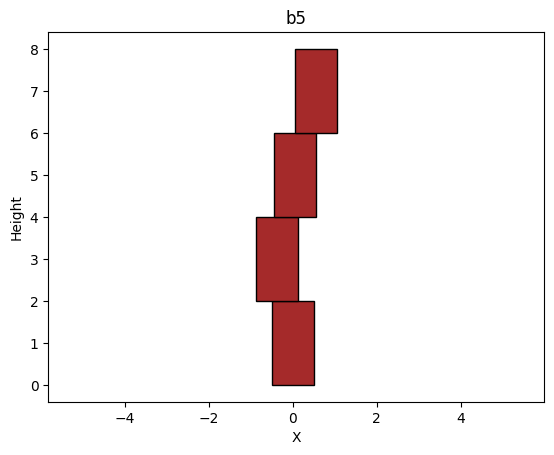

Saving plot to output/b5.png)
Detected 6 color blocks.
Plotting c5 brick wall


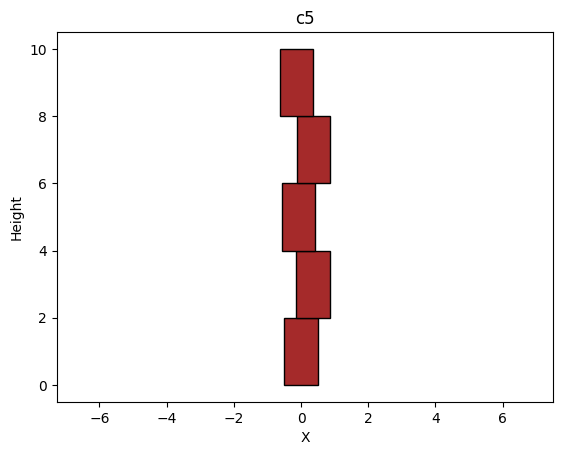

Saving plot to output/c5.png)
Detected 10 color blocks.
Plotting d5 brick wall


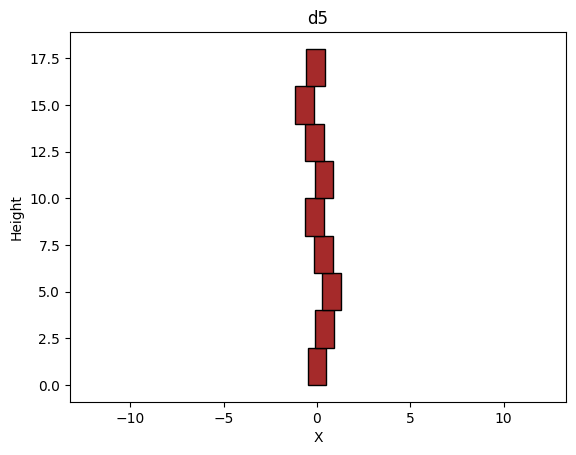

Saving plot to output/d5.png)
Detected 8 color blocks.
Plotting e5 brick wall


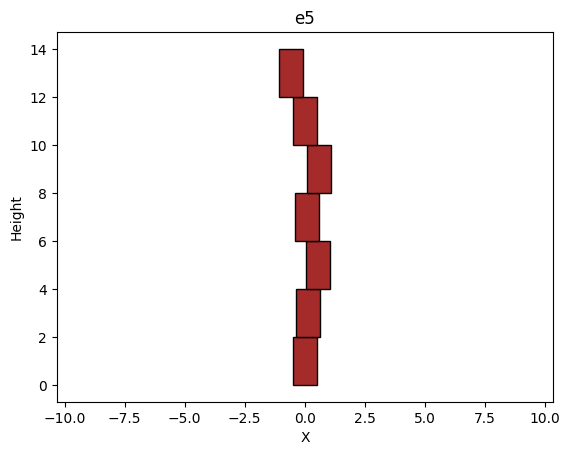

Saving plot to output/e5.png)
Detected 5 color blocks.
Plotting f5 brick wall


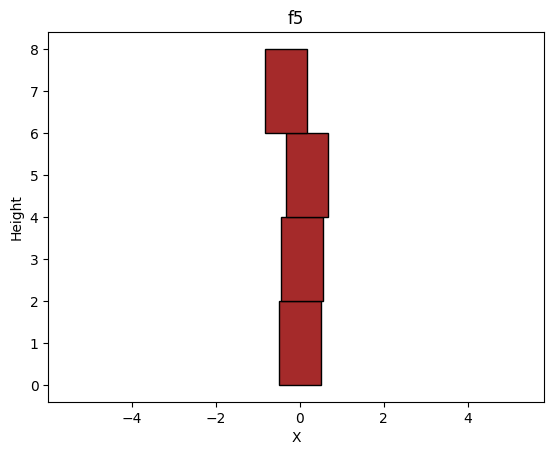

Saving plot to output/f5.png)
Detected 6 color blocks.
Plotting g5 brick wall


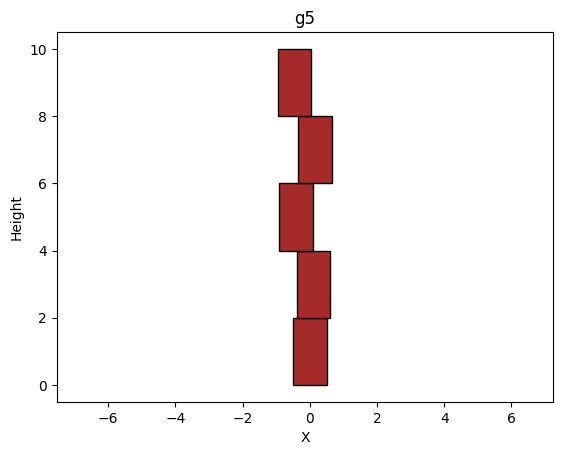

Saving plot to output/g5.png)
Detected 10 color blocks.
Plotting h5 brick wall


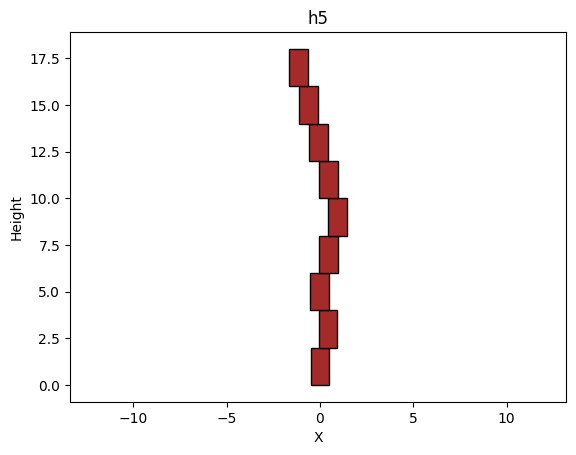

Saving plot to output/h5.png)
Detected 11 color blocks.
Plotting a6 brick wall


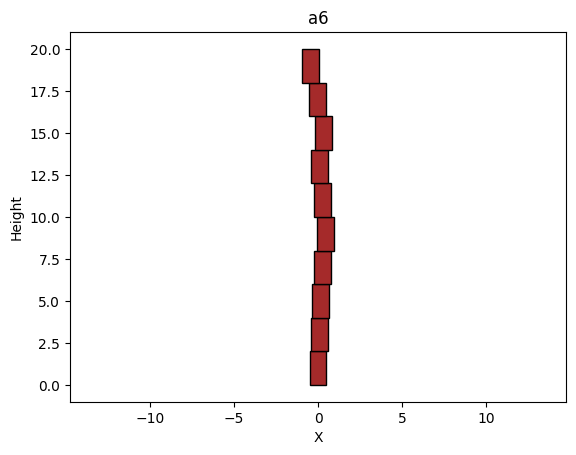

Saving plot to output/a6.png)
Detected 7 color blocks.
Plotting b6 brick wall


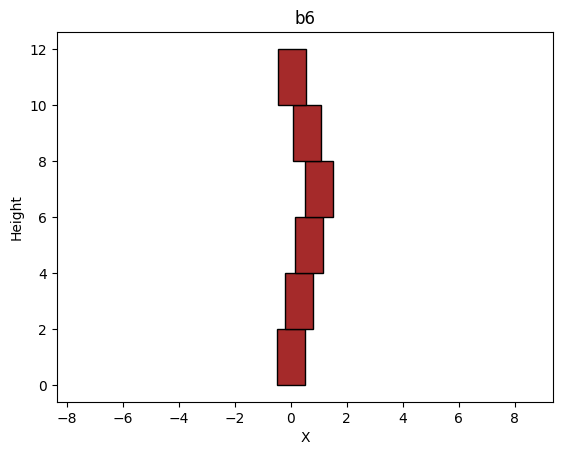

Saving plot to output/b6.png)
Detected 9 color blocks.
Plotting c6 brick wall


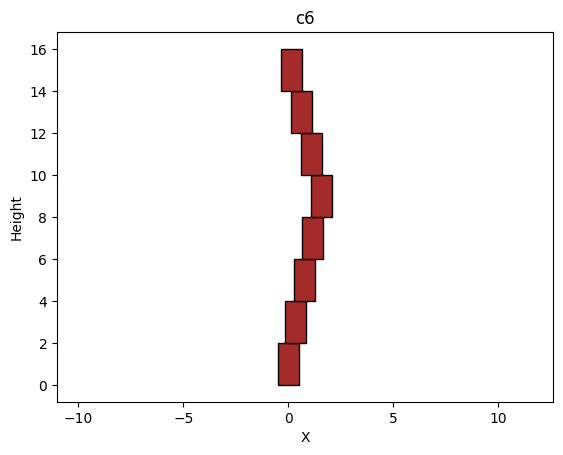

Saving plot to output/c6.png)
Detected 10 color blocks.
Plotting d6 brick wall


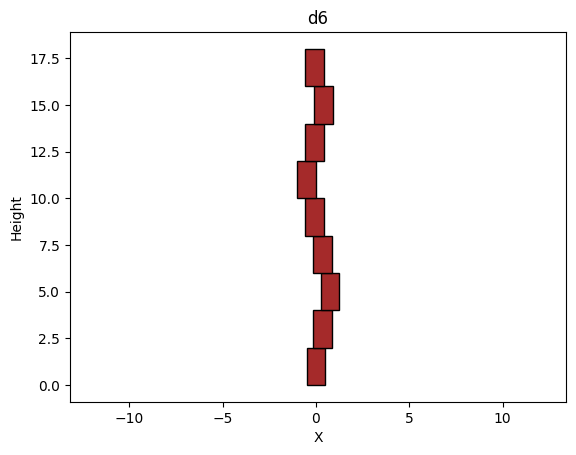

Saving plot to output/d6.png)
Detected 6 color blocks.
Plotting e6 brick wall


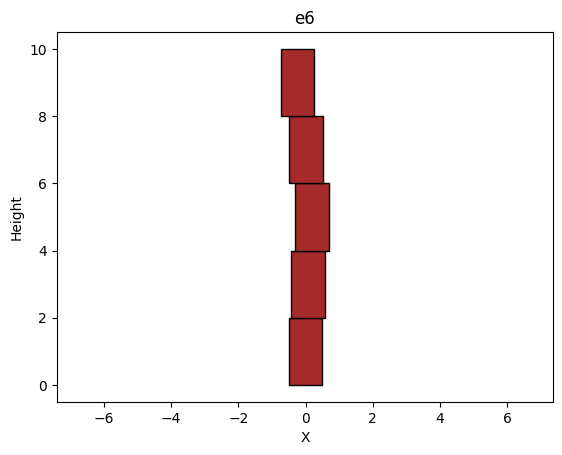

Saving plot to output/e6.png)
Detected 4 color blocks.
Plotting f6 brick wall


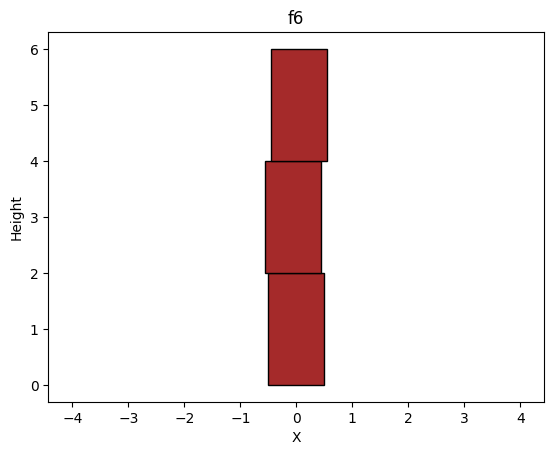

Saving plot to output/f6.png)
Detected 5 color blocks.
Plotting g6 brick wall


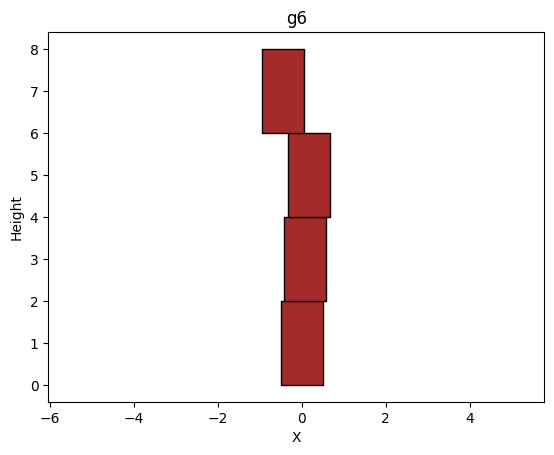

Saving plot to output/g6.png)
Detected 8 color blocks.
Plotting h6 brick wall


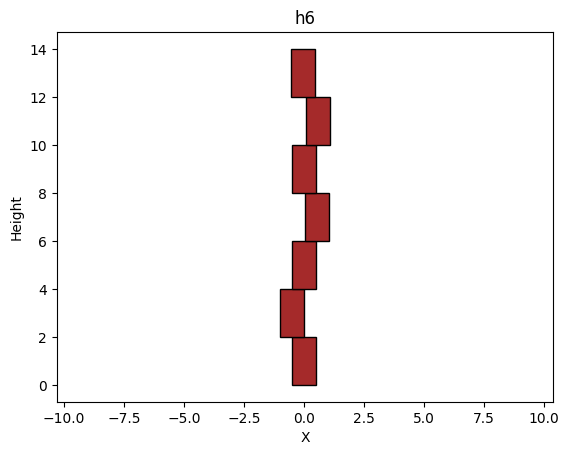

Saving plot to output/h6.png)
Detected 7 color blocks.
Plotting a7 brick wall


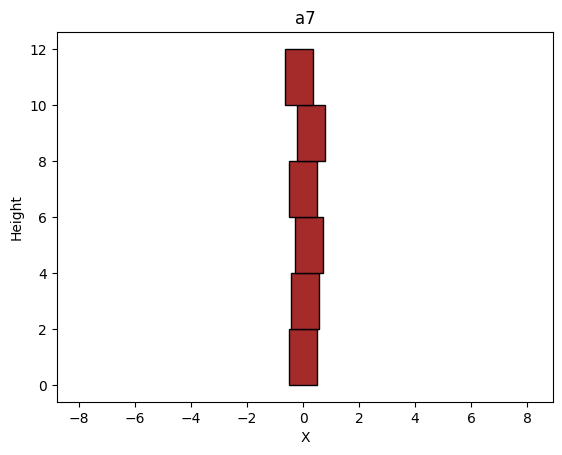

Saving plot to output/a7.png)
Detected 7 color blocks.
Plotting b7 brick wall


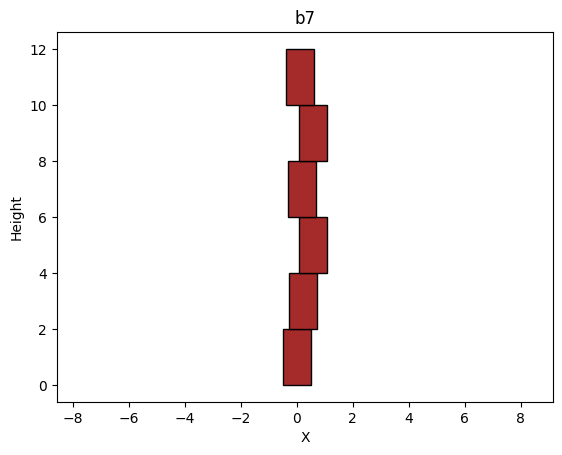

Saving plot to output/b7.png)
Detected 4 color blocks.
Plotting c7 brick wall


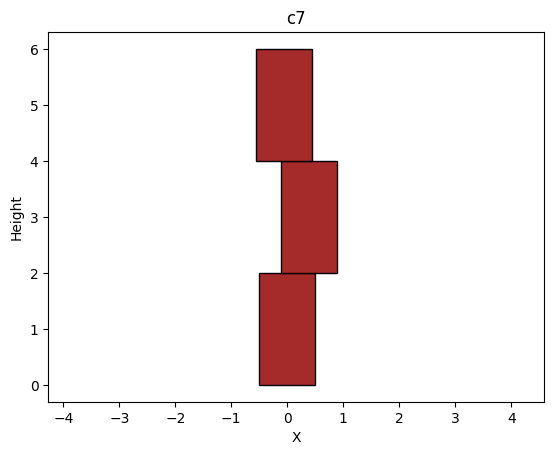

Saving plot to output/c7.png)
Detected 7 color blocks.
Plotting d7 brick wall


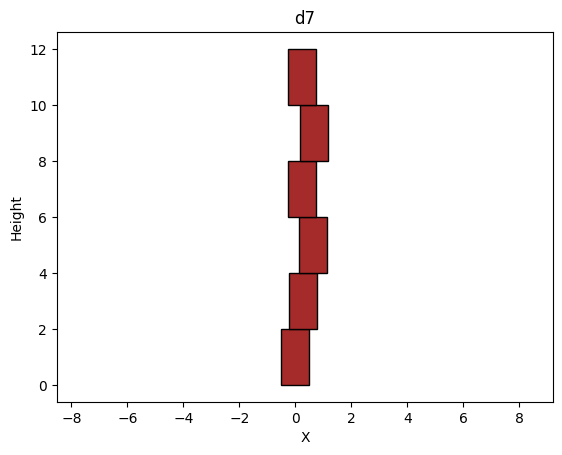

Saving plot to output/d7.png)
Detected 8 color blocks.
Plotting e7 brick wall


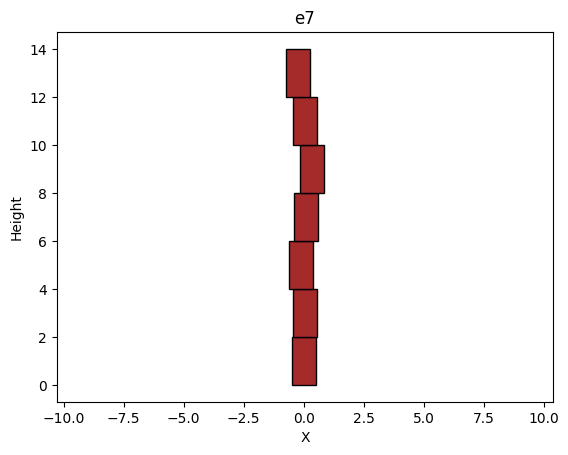

Saving plot to output/e7.png)
Detected 5 color blocks.
Plotting f7 brick wall


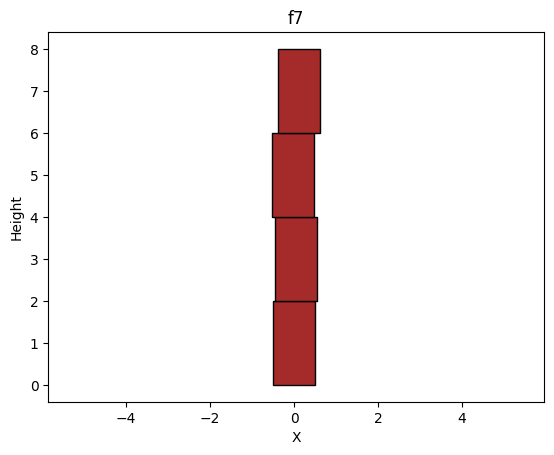

Saving plot to output/f7.png)
Detected 6 color blocks.
Plotting g7 brick wall


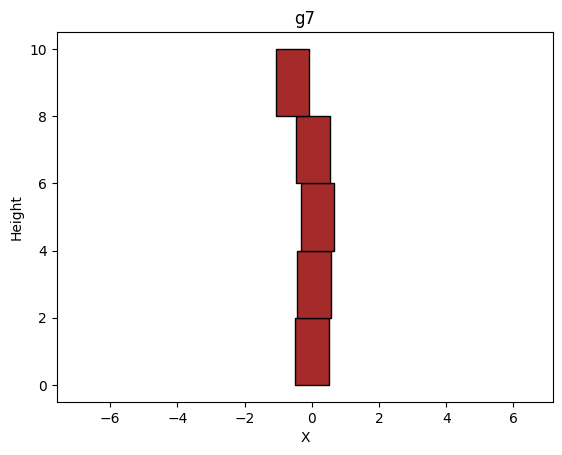

Saving plot to output/g7.png)
Detected 6 color blocks.
Plotting h7 brick wall


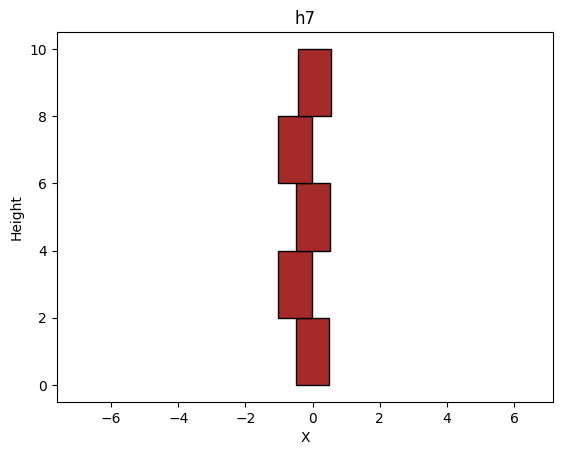

Saving plot to output/h7.png)
Detected 5 color blocks.
Plotting a8 brick wall


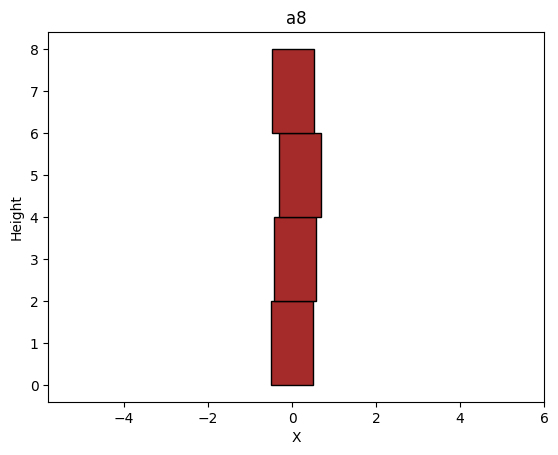

Saving plot to output/a8.png)
Detected 7 color blocks.
Plotting b8 brick wall


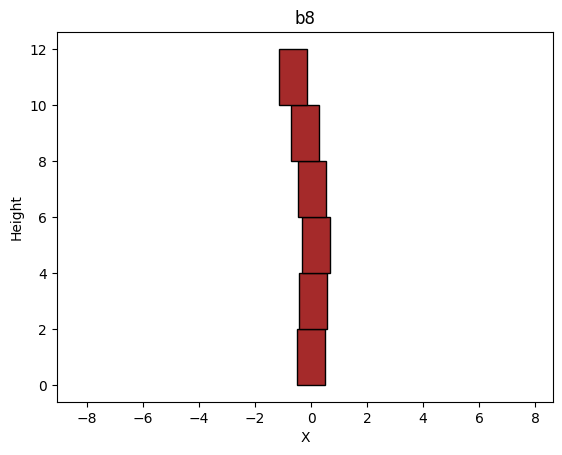

Saving plot to output/b8.png)
Detected 7 color blocks.
Plotting c8 brick wall


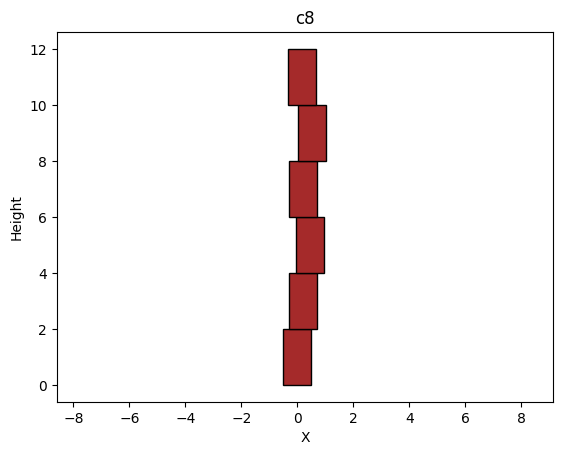

Saving plot to output/c8.png)
Detected 6 color blocks.
Plotting d8 brick wall


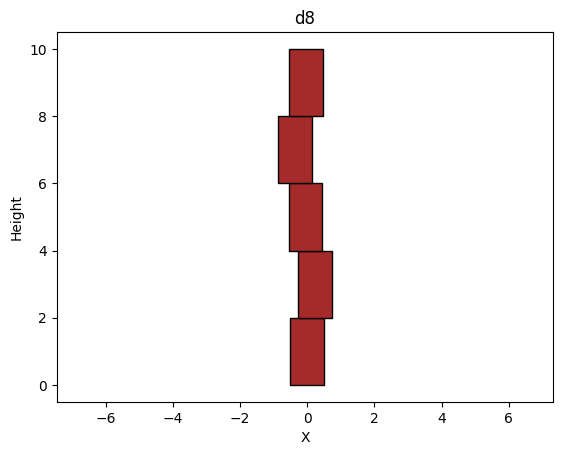

Saving plot to output/d8.png)
Detected 4 color blocks.
Plotting e8 brick wall


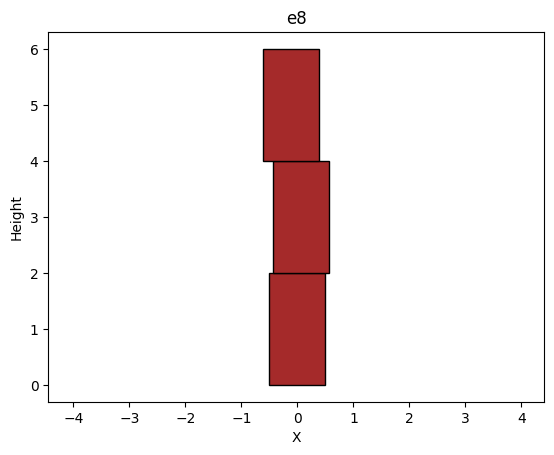

Saving plot to output/e8.png)
Detected 5 color blocks.
Plotting f8 brick wall


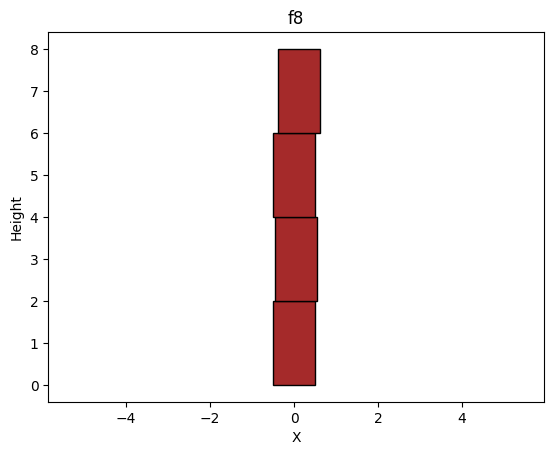

Saving plot to output/f8.png)
Detected 7 color blocks.
Plotting g8 brick wall


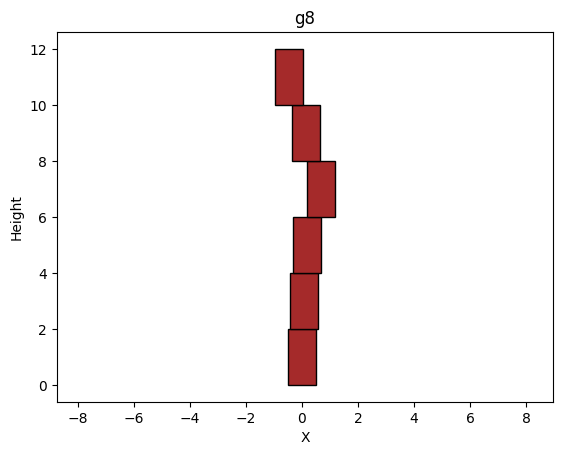

Saving plot to output/g8.png)
Detected 6 color blocks.
Plotting h8 brick wall


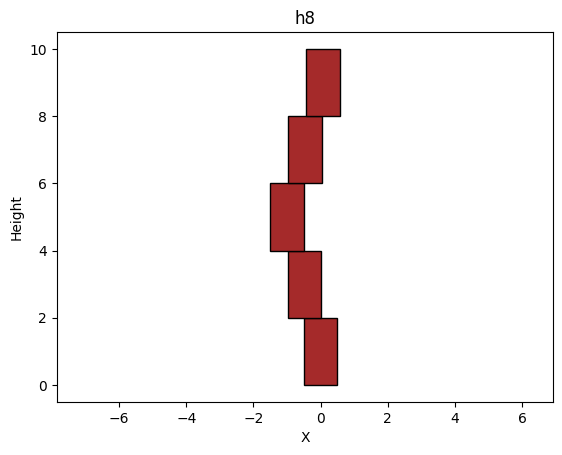

Saving plot to output/h8.png)
Detected 3 color blocks.
Plotting a9 brick wall


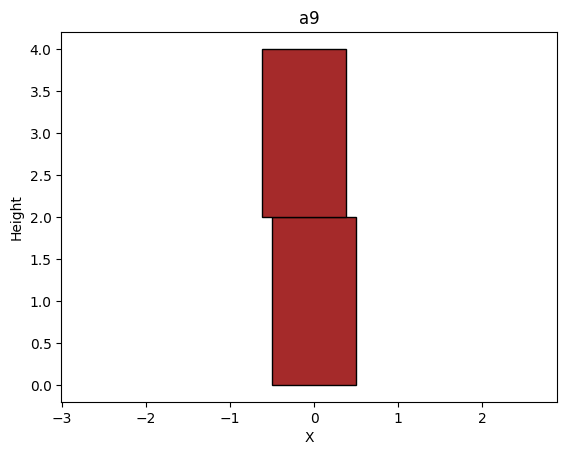

Saving plot to output/a9.png)
Detected 7 color blocks.
Plotting b9 brick wall


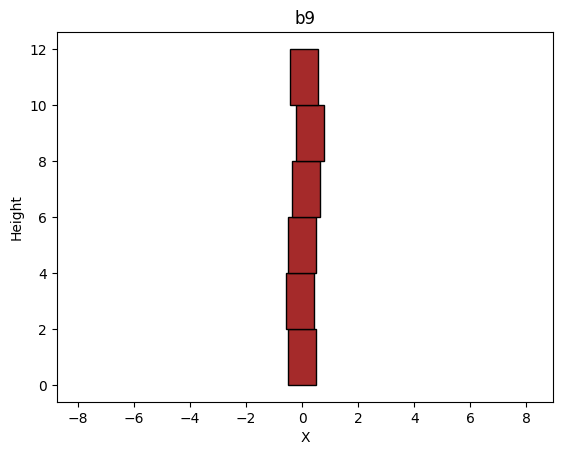

Saving plot to output/b9.png)
Detected 5 color blocks.
Plotting c9 brick wall


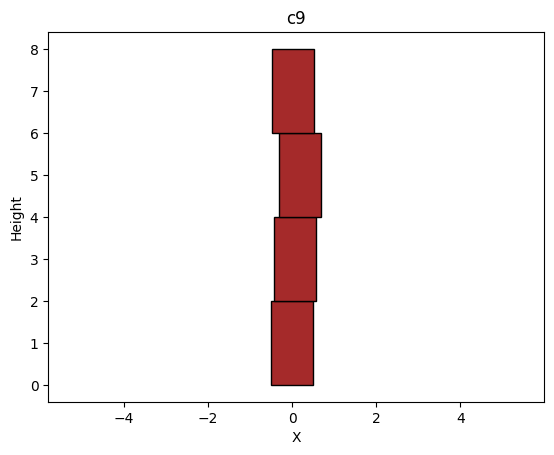

Saving plot to output/c9.png)
Detected 6 color blocks.
Plotting d9 brick wall


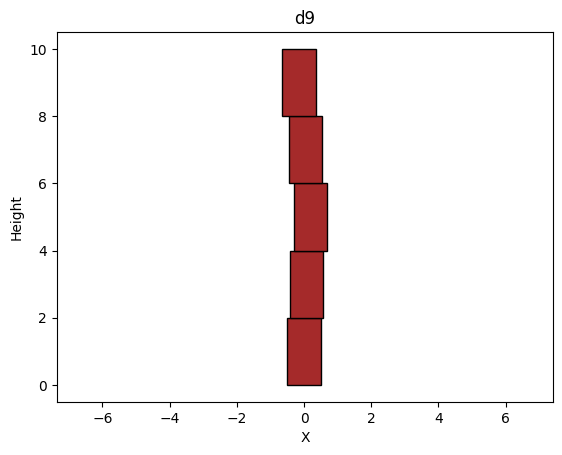

Saving plot to output/d9.png)
Detected 6 color blocks.
Plotting e9 brick wall


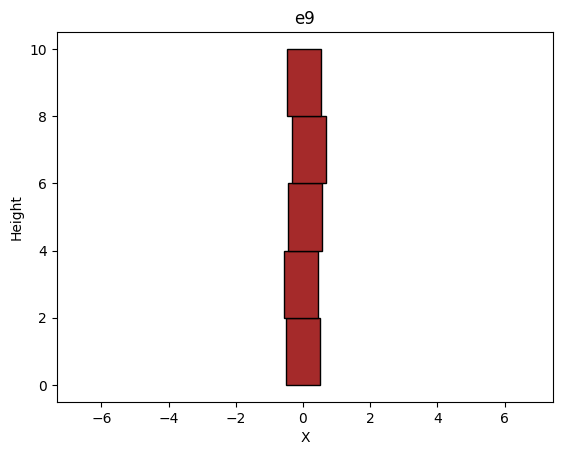

Saving plot to output/e9.png)
Detected 6 color blocks.
Plotting f9 brick wall


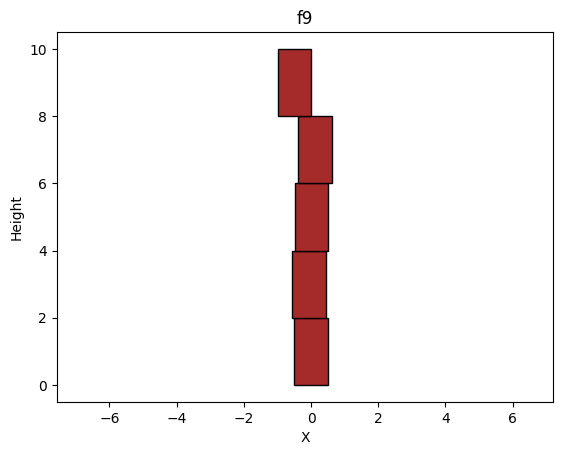

Saving plot to output/f9.png)
Detected 10 color blocks.
Plotting g9 brick wall


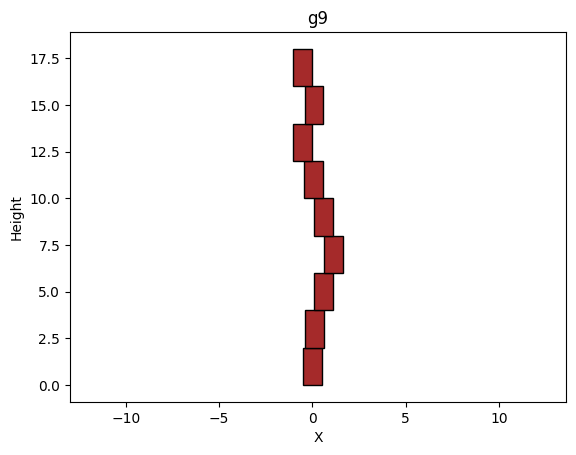

Saving plot to output/g9.png)
Detected 5 color blocks.
Plotting h9 brick wall


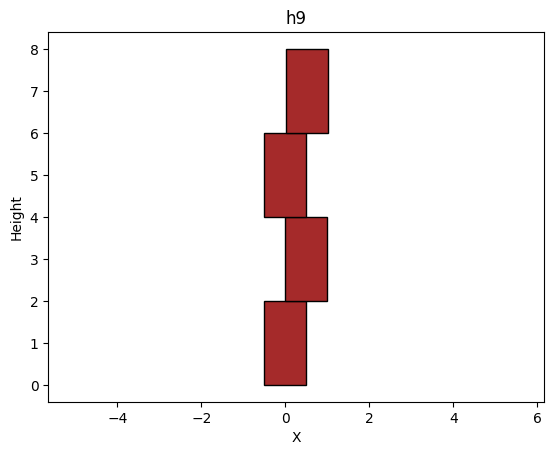

Saving plot to output/h9.png)
Detected 1 color blocks.
No color parameters found for a10
Detected 3 color blocks.
Plotting b10 brick wall


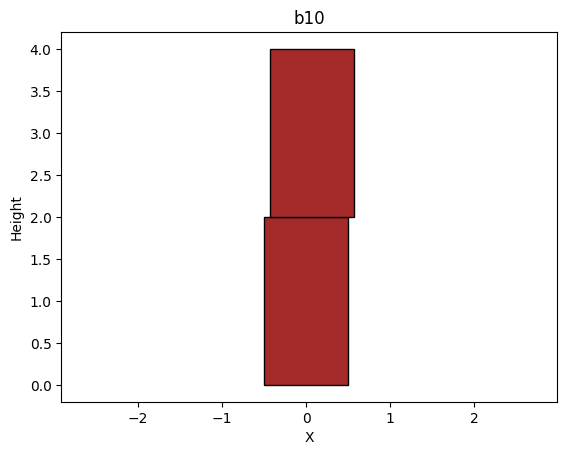

Saving plot to output/b10.png)
Detected 5 color blocks.
Plotting c10 brick wall


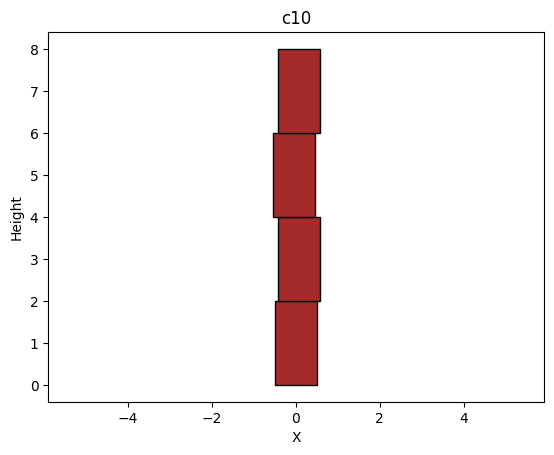

Saving plot to output/c10.png)
Detected 7 color blocks.
Plotting d10 brick wall


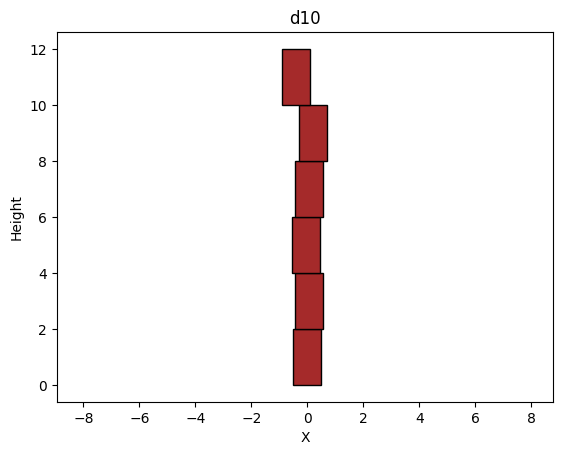

Saving plot to output/d10.png)
Detected 6 color blocks.
Plotting e10 brick wall


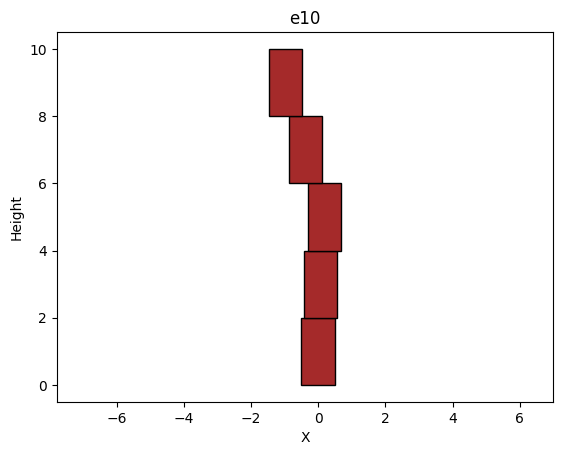

Saving plot to output/e10.png)
Detected 10 color blocks.
Plotting f10 brick wall


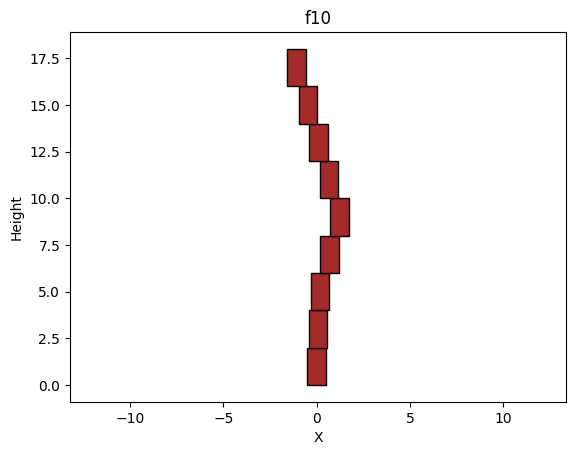

Saving plot to output/f10.png)
Detected 4 color blocks.
Plotting g10 brick wall


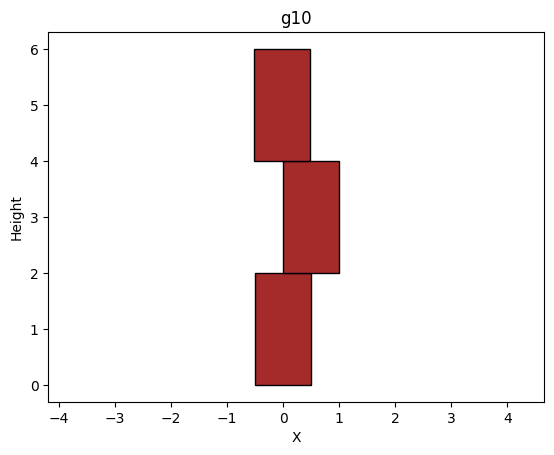

Saving plot to output/g10.png)
Detected 1 color blocks.
No color parameters found for h10


In [33]:
from matplotlib.patches import Rectangle
import os

DEBUG = False


def plot_brickwall(color_params: list[tuple[int, int, int]], title="profile"):
    # Initial
    single_brick_width = 1
    single_brick_height = 2
    current_x = -single_brick_width / 2
    current_height = 0

    if color_params is None or len(color_params) == 0:
        print(f"No color parameters found for {title}")
        return
    
    fig, ax = plt.subplots()
    print(f"Plotting {title} brick wall")
    # remove black color
    min_x, min_y, min_z = 0, 0, 0
    max_x, max_y, max_z = 255, 255, 255
    clean_color_params = []
    for color in color_params:
        x, y, z = color
        if sum(color) < 30:
            continue
        if min_x > x:
            min_x = x
        if min_y > y:
            min_y = y
        if min_z > z:
            min_z = z
        if max_x < x:
            max_x = x
        if max_y < y:
            max_y = y
        if max_z < z:
            max_z = z
        clean_color_params.append(color)

    # Calculate the median z value
    median_z = np.median([z for _, _, z in clean_color_params])

    # Loop through the bricks
    for params in clean_color_params:
        # Unpack the tuple
        x, y, z = params
        # Decorate the plot with the brick parameters
        offset = (x - min_x) / (max_x - min_x) * (2 / 3)
        thickness = 1
        direction = 1 if z < median_z else -1

        if DEBUG:
            print("offset, thickness, direction")
            print(f"{offset:.1f}, {thickness:.1f}, {direction:.1f}")

        # Initialize figure and axis

        # Draw each brick
        for _ in range(int(thickness)):
            ax.add_patch(
                Rectangle(
                    (current_x, current_height),
                    single_brick_width,
                    single_brick_height,
                    facecolor="brown",
                    edgecolor="black",
                )
            )
            current_height += single_brick_height
        # Update the current position for the next brick
        current_x += offset * direction

    # Set labels and title
    ax.set_xlabel("X")
    ax.set_ylabel("Height")
    ax.set_title(title)
    # scale the plot as show all
    ax.autoscale_view()
    plt.axis("equal")
    # remove

    # Show the plot
    plt.show()
    # save plot to file, create output folder if not exists
    if not DEBUG:
        if not os.path.exists('output'):
            os.makedirs('output')
        print(f"Saving plot to output/{title}.png)")
        fig.savefig(f'output/{title}.png')

    plt.close(fig)


# Assuming cells is a dictionary with cell labels as keys and cell image arrays as values
# Assuming find_color_blocks is defined as provided earlier

def extract_unique_colors(annotated_image):
    """Extract unique RGB colors from the annotated image."""
    flattened_colors = annotated_image.reshape((-1, 3))
    unique_colors_array = np.unique(flattened_colors, axis=0)
    unique_colors_list = [tuple(color) for color in unique_colors_array if np.any(color != [0, 0, 0])]  # Exclude black
    return unique_colors_list


def custom_graph_function(unique_colors, cell_label):
    """A custom function to graph or process the unique colors of a cell."""
    # Example: Simply print the unique colors for each cell
    print(f"Cell {cell_label} has unique colors: {len(unique_colors)}")
    # You can replace this with your actual graphing or processing code


# Loop through each cell in the cells dictionary
for cell_label, cell_image_array in cells.items():
    # Run find_color_blocks on the cell image array
    annotated_cell_image, n_color_blocks = find_color_blocks_dbscan(cell_image_array)

    # Extract the unique RGB colors from the annotated image
    unique_colors = extract_unique_colors(annotated_cell_image)

    # Pass the unique colors to the custom function for further processing
    plot_brickwall(unique_colors, cell_label)